# Part 2. Propensity Score Matching

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
#!pip install xgboost
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold

In [7]:
file_path_2020 = '2020_survey_data_cleansed.csv'
df = pd.read_csv(file_path_2020)
df.head()

,RES_AGE,RES_SEX,B1,B3,B4,B4_1_etc,B5_1_etc_1,B5_1_etc_2,B5_2_etc_1,B5_2_etc_2,...,D7_3_3,D11_2_SUM,D13_SUM,D14_SUM,H3_SUM,H4_SUM,H13_SUM,H14_1_SUM,H16_SUM,E1_3_1
0,67,2,2,2,1,1,0,0,0,0,...,0,2,9.0,0,30,17,0,0,18.28062,1
1,68,2,2,2,1,2,0,0,1,7,...,0,2,7.0,2,30,17,0,0,15.13697,0
2,66,2,2,1,1,1,0,0,1,3,...,0,0,8.0,0,15,21,0,0,18.00000,0
3,66,1,2,1,1,1,0,0,0,0,...,0,0,11.0,0,15,18,0,0,17.00000,0
4,68,2,3,4,1,1,0,0,1,3,...,0,3,2.0,3,16,20,0,0,23.13697,1


features 묶음은 아래와 같습니다
1. 건강상태 관련
 - health_essential
 - health_raw
 - health_compound
2. 가족/사회관계 관련
 - social_essential
 - social_raw
 - social_compound
3. 노후생활 관련
 - life_essential
 - life_raw
 - life_compound

In [8]:
# health-related features
health_essential = ['RES_AGE','RES_SEX','B1','B3','B4','B4_1_etc','B5_1_etc_1','B5_1_etc_2','B5_2_etc_1','B5_2_etc_2','B7','B8','B8_1a','B9','C4','C10_1_2','I1x1']
health_raw = ['B2_2L_1','B2_2L_2','B2_2L_3','B2_2L_4','B2_2L_5','B2_2L_6','B2_2L_7','B2_2L_8','B2_2L_9','B2_2L_10','B2_2L_11','B2_2L_12','B2_2L_13','B2_2L_14','B2_2L_15','B2_2L_16','B2_2L_17','B2_2L_18','B2_2L_19','B2_2L_20','B2_2L_21','B2_2L_22','B2_2L_23','B2_2L_24','B2_2L_25','B2_2L_26','B2_2L_27','B2_2L_28','B2_2L_29','B2_2L_30','B2_2L_31','B2_2L_32',
              'B6_1','B6_2','B6_3','B6_4','B6_5','B6_6','B6_7','B6_8','B6_9','B6_10','B6_11','B6_12','B6_13','B6_14','B6_15',
              'B9_1a','B9_2a',
              'B10_1','B10_3',
              'B11_1','B11_2','B11_3_1','B11_3_2','B11_3_3','B11_4','B11_5','B11_6','B11_7','B11_8','B11_9','B11_10',
              'C1_1','C2_1','C3_1',
              'C1_2','C2_2','C3_2',
              'C5_1','C5_2','C5_3','C5_4','C5_5','C5_6',
              'C6_1','C6_2','C6_3','C6_4','C6_5','C6_6','C6_7',
              'C7_1_1','C7_1_2','C7_1_3','C7_1_4','C7_1_5','C7_1_6','C7_1_7',
              'C7_2_8','C7_2_9','C7_2_10',
             ]
health_compound = ['B2_3','B6_SUM','B9_3a','B10_BMI','B11_SUM','C_SUM_1','C_SUM_2','C5_SUM','C_6_7_SUM']
health_features_1 = health_essential + health_raw
health_features_2 = health_essential + health_compound

# social-related features
social_essential = ['EDM','S5_1','S5_2','S6_1','S6_2','S6_3','S6_4','S6_5','F1_1_2_1','F1_1_2_2','F1_1_3_1','F1_1_3_2','F2','F2_1','F5_1_etc','F5_1','F5_2','G4_1','F6','F13_1_etc','F14','F14_1','F15','F15_1','F16_1','F16_2','AREA_11','AREA_21','AREA_22','AREA_23','AREA_24','AREA_25','AREA_26','AREA_29','AREA_31','AREA_32','AREA_33','AREA_34','AREA_35','AREA_36','AREA_37','AREA_38','AREA_39']
social_raw = ['G1_4_7','G1_4_8','G1_4_9','G1_4_10','G1_4_11','G1_4_12','G2_4_7','G2_4_8','G2_4_9','G2_4_10','G2_4_11','G2_4_12','G3_4_7','G3_4_8','G3_4_9','G3_4_10','G3_4_11','G3_4_12']
social_compound = ['G1_4_AGG','G2_4_AGG','G3_4_AGG']
social_features_1 = social_essential + social_raw
social_features_2 = social_essential + social_compound

# life-quality-related features
life_essential = ['D1_1_etc','D2','D3','D6_1_1','D6_1_2','D6_1_3','D8_1','H1_1','H1_2','H1_3','H1_4','H1_5','H2','H11','H12_1_etc','H15','H18','H25']
life_raw = ['D5_3_1','D5_3_2','D7_3_1','D7_3_2','D11_2_1','D11_2_2','D11_2_3','D11_2_4','D11_2_5','D11_2_6',
'D13_1','D13_2','D13_3','D13_4','D13_5','D13_6','D13_7','D13_8','D13_9','D13_10','D13_11',
'D14_1','D14_2','D14_3',
'H3_1','H3_2','H3_3','H3_4','H3_5','H3_6','H3_7',
'H4_1','H4_2','H4_3','H4_4','H4_5','H4_6','H4_7',
'H13_1','H13_2','H13_3','H13_4','H13_5','H13_6',
'H14_1_1','H14_1_2','H14_1_3','H14_1_4','H14_1_5','H14_1_6',
'H16_1','H16_2','H16_3','H16_4','H16_5','H16_6','H16_7']
life_compound = ['D5_3_3','D7_3_3','D11_2_SUM','D13_SUM','D14_SUM','H3_SUM','H4_SUM','H13_SUM','H14_1_SUM','H16_SUM']
life_features_1 = life_essential + life_raw
life_features_2 = life_essential + life_compound

# 1. Treatment T

여기서 treatment는 정부 지원 일자리 프로그램 참여여부입니다.

컬럼 이름은 **E1_3_1**이며 0(참여하지 않음)과 1(참여함), 두가지 값을 받고 있습니다.

분포도는 아래와 같습니다.

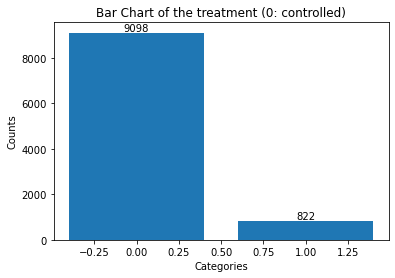

In [12]:
values = df['E1_3_1'].value_counts()
labels = values.index
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Bar Chart of the treatment (0: controlled)')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()